## TS9

#### Franco Ruggiero

 *Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de d*

  <img src="img_1_plantilla.svg" style="width:600px ; height:420px">

 *y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:*

a) módulo,

b) fase

c) retardo

d) y respuesta al impulso.

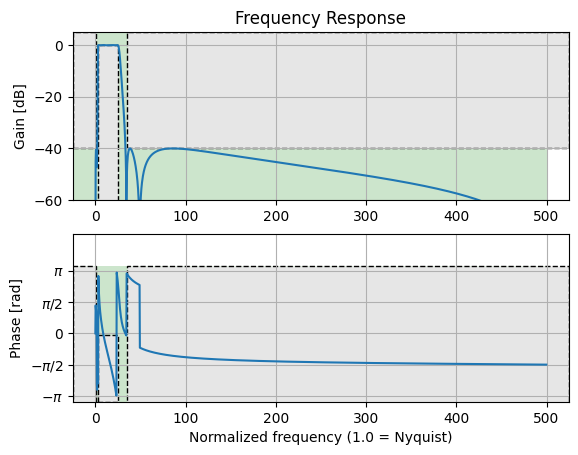

In [2]:
"""
Created on Thu Sep  5 09:00:57 2024

@author: franco
"""
##########################################################
#
#   IIR
#
##########################################################

# %matplotlib ipympl
# %matplotlib qt   
# %matplotlib inline

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16


# Plantilla
# filter design

fs = 1000 # Hz
nyq_frec = fs / 2

ripple = 0.1 # dB
atenuacion = 40 # dB
gpass = ripple
gstop = atenuacion

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)


wp = [wp1 , wp2]
ws = [ws1 , ws2]

myIIR_SOS = sig.iirdesign(wp, ws, gpass, gstop, analog=False, ftype='ellip', output='sos', fs=fs)

w, h = sig.sosfreqz(myIIR_SOS, worN=1500 , fs=fs)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))

plt.plot(w, db)
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.ylim(-40, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

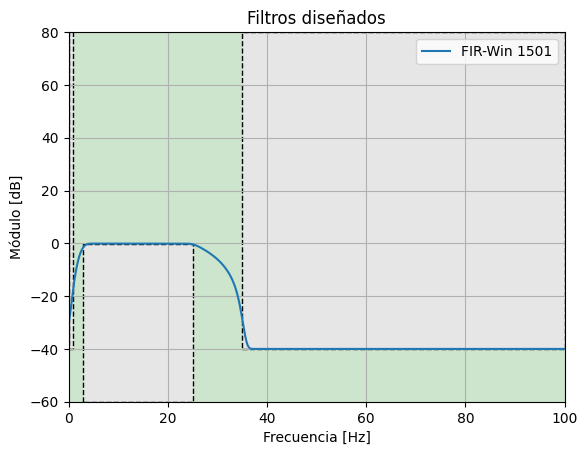

In [3]:
##########################################################
#
#   FIR
#
##########################################################

# %matplotlib qt
# %matplotlib inline

# num_firls_hp = sig.firls(numtaps, bands, desired, *, weight=None, fs=None)
# num_remez_hp = sig.remez(numtaps, bands, desired, *, weight=None, type='bandpass', maxiter=25, grid_density=16, fs=None)
# num_win      = sig.firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, fs=None)
# num_win2     = sig.firwin2(numtaps, freq, gain, *, nfreqs=None, window='hamming', antisymmetric=False, fs=None)

#cuadrados minimos
# num_win = sig.firls(numtaps, bands, desired, *, weight=None, fs=None)



cant_coeficientes = 1501

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris')
# num_win = sig.firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, fs=None)
# num_win = sig.firls(numtaps, bands, desired, *, weight=None, fs=None)
# num_win = sig.remez(numtaps, bands, desired, *, weight=None, type='bandpass', maxiter=25, grid_density=16, fs=None)


#cuadrados minimos
# desired = [ 1, 1, 40000 ]
# num_win = sig.firls(cant_coeficientes, frecs, gains, desired)


den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 80 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

### Parte 2

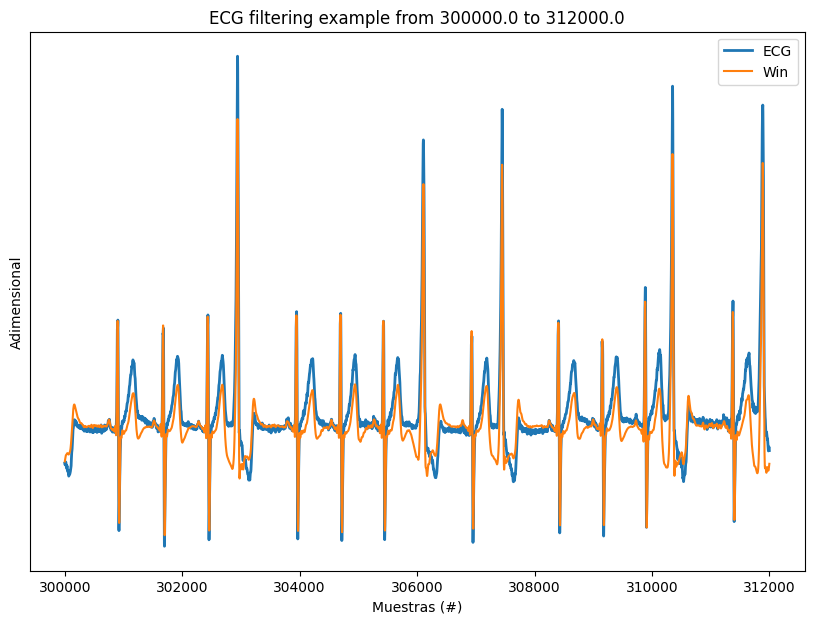

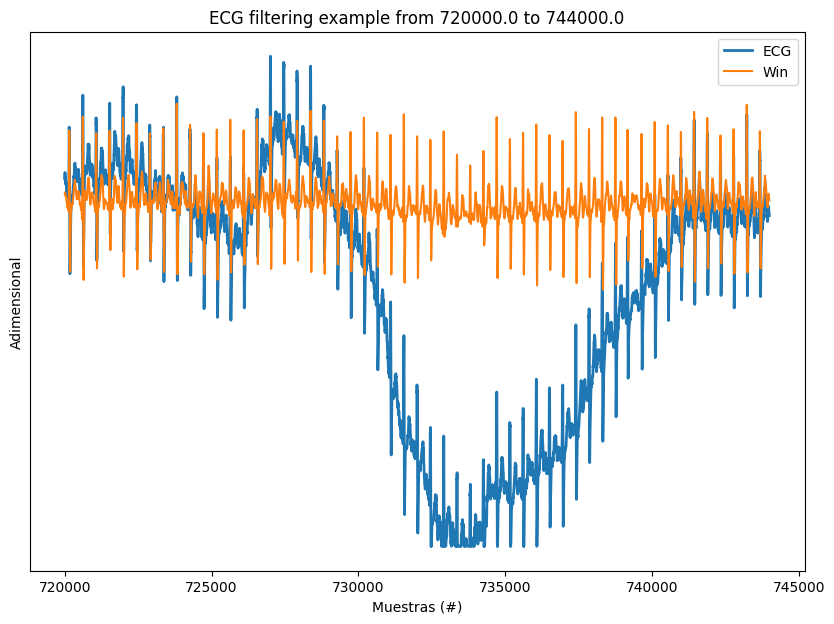

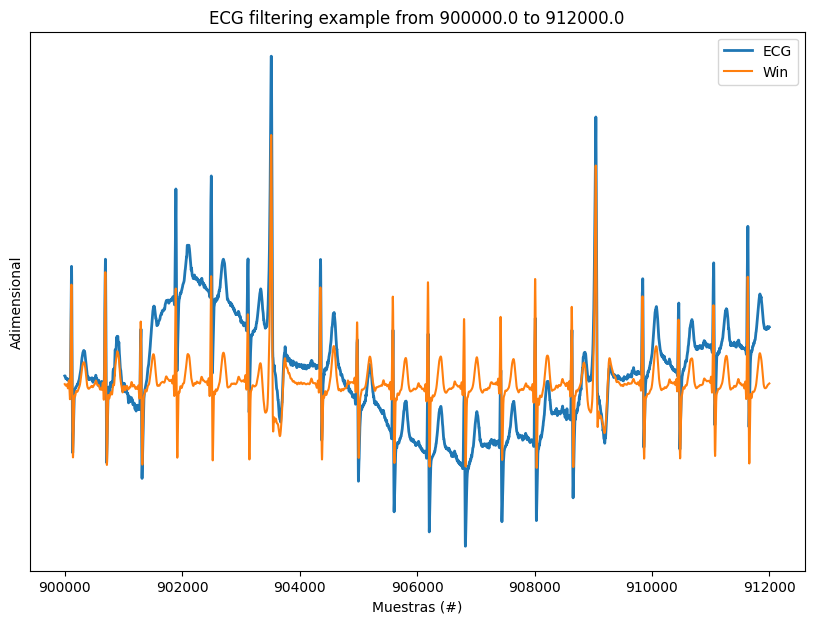

In [6]:
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

################################################################################################


# %matplotlib qt
# %matplotlib inline

# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)


# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()